In [1]:
# %load defaults.ipy
# %load defaults.ipy
import sys
import os
import collections
for p in sys.path:
    if 'netcdf' in p.lower():
        sys.path.remove(p)
    if 'matplotlib' in p.lower():
        sys.path.remove(p)
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 300
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML

import PIL

sys.path.append('../python')

from plot_info import showAndSave, legendLeft, savePlot

qmc_base_folder=os.environ.get('QMC_EXPERIMENTS_BASE_FOLDER', '../data/')
print(qmc_base_folder)    
def compute_and_plot_speedup(number_of_samples, errors, errors_mc, label):
    speedups = []
    
    for index_method, (samples_method, error_from_method) in enumerate(zip(number_of_samples[:len(errors)], errors)):
        # We try to find a corresponding Monte Carlo error
        for samples_mc, error_from_mc in zip(number_of_samples, errors_mc):
            relative_deviation = abs(error_from_method-error_from_mc)/error_from_method
            
            if relative_deviation < 0.01:
                speedup = samples_mc / samples_method
                break
        else:
            # We never found an error close enough
            
            error_from_mc = errors_mc[index_method]
            
            error_ratio =  error_from_mc / error_from_method
            
            convergence_rate_mc = 0.5
            
            speedup = error_ratio**convergence_rate_mc
            
        speedups.append(speedup)
        
    
    plt.loglog(number_of_samples[:len(speedups)], speedups, '-o', label=label, basex=2, basey=2)
    plt.xlabel("Number of samples")
    plt.ylabel("Speedup")
    
    ylims = plt.gca().get_ylim()
    plt.ylim([ylims[0], max(2.4, ylims[1])])
    plt.xticks(number_of_samples[:len(speedups)], [f'${M}$' for M in number_of_samples[:len(speedups)]])
    
    
            
        

../data/


In [2]:
import sys
import alsvinn

In [3]:
import re
def computeConvergence(basename, normP, allFiles, 
                       showSingle=False, showRes=False, statistics='mean', upTo=-1,
                       all_mc_errors=None, maxMexponent=18):
    # This run always fails, so we skip it
    if 'nieder' in basename or 'latin_center' in basename:
        return
    if 'kelvinhelmholtz' in basename:
        name = re.search(r'kelvinhelmholtz_([^/]+)\/', basename).group(1)
    else:
        name = re.search(r'brownian_(.+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 256
    if showSingle:
        display(HTML("<h1>%s</h1>" % name))
    
    exponents = list(range(6,maxMexponent))
    Ms = 2**array(exponents)
    
    plotted_names = {}
    
    all_errors = collections.defaultdict(dict)
    
    ######## CAUCHY CONVERGENCE
    for t in [0,1]:
        plt.figure(t)
        plotted_names[t] = 'cauchy_convergence_%d_%d_%s' % (normP, t, statistics)
        errors = []
        
        for M in Ms:
            filename = basename.format(M=M)
            try:
                r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('rho', timestep=t, statistics=statistics)
            
            
            if M > Ms[0]:
                errors.append((sum(abs(mean-meanPrev)**normP)/mean.shape[0]**2)**(1.0/normP))
            meanPrev = mean
            if showRes:
                x,y = mgrid[0:1:N*1j, 0:1:N*1j]
                plt.pcolormesh(x,y, mean)
                plt.ylabel('$y$')
                plt.xlabel('$x$')
                #plt.title('%s, $M=%d$' % (name, M))
                plt.colorbar()
                showAndSave('single_%s_%d_%s_%d' % (name, M, statistics, t))
        p = plt.loglog(Ms[:-1], errors, '-o',label=name, basex=2, basey=2)
        poly = polyfit(log(Ms[:-1]), log(errors), 1)
        
        plt.loglog(Ms[:-1], exp(poly[1])*Ms[:-1]**poly[0], '--', 
                   color=p[0].get_color(), label='$\\mathcal{O}(M^{%.3f})$' % poly[0], basex=2, basey=2)
        plt.xlabel("M")
        plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
        
        
        if not showSingle:
            pass
            plt.title("Cauchy convergence at $T=%d$ (normalized time)\n%s\nresolution=$256 \\times 256$" % (t, statistics))
        legendLeft()
        plt.xticks(Ms[:upTo], [f'${M}$' for M in Ms[:upTo]])
        if showSingle:
            
            #plt.title("Cauchy Convergence for %s at $T=%d$ (normalized time)\n%s\nresolution=$256 \\times 256$" % (name,t, statistics))
            showAndSave('cauchy_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))
    
        
        plt.figure(20+t)
        plotted_names[20+t] = 'speedup_cauchy_convergence_%d_%d_%s' % (normP, t, statistics)
        all_errors['cauchy'][t] = errors
        if 'monte carlo' not in name.lower():
            mc_errors = all_mc_errors['cauchy'][t]
        else:
            mc_errors = errors
        compute_and_plot_speedup(Ms[:-1], errors, mc_errors, name)
        legendLeft()
    
    ######## SELF REFERENCE CONVERGENCE
    for t in [0,1]:
        filename = basename.format(M=Ms[-1])
        try:
            r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
        except Exception as e:
            print("%s failed, see error message below: " % name)
            print (e)
            return
        errors = []
        plt.figure(2+t)
        plotted_names[2+t] = 'reference_convergence_%d_%d_%s' % (normP, t, statistics)
        
        referenceSolution = r.get_data('rho', timestep=t, statistics=statistics)
        
        for M in Ms[:upTo]:
            filename = basename.format(M=M)
            try:
                r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('rho', timestep=t, statistics=statistics)
               
            
            
            errors.append((sum(abs(mean-referenceSolution)**normP)/mean.shape[0]**2)**(1.0/normP))
           
        p = plt.loglog(Ms[:upTo], errors, '-o',label=name)
        poly = polyfit(log(Ms[:upTo]), log(errors), 1)
        
        plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--',
                   color=p[0].get_color(), label='$\\mathcal{O}(M^{%.3f})$' % poly[0], basex=2, basey=2)
        plt.xlabel("M")
        plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
        if not showSingle:
            pass
            #plt.title("Self convergence against reference solution $M=%d$\n$T=%d$ (normalized time)\n%s\nresolution=$256 \\times 256$" % (Ms[-1], t, statistics))
        
        legendLeft()
        plt.xticks(Ms[:upTo], [f'${M}$' for M in Ms[:upTo]])
        if showSingle:
            #plt.title("Self convergence for %s at $T=%d$ (normalized time)\nagainst reference solution with $M=%d$ samples\n%s\nresolution=$256 \\times 256$" % (name,t,Ms[-1],statistics))
            showAndSave('self_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))
        
        
        
        plt.figure(30+t)
        plotted_names[30+t] = 'speedup_self_convergence_%d_%d_%s' % (normP, t, statistics)
        all_errors['self_convergence'][t] = errors
        if 'monte carlo' not in name.lower():
            mc_errors = all_mc_errors['self_convergence'][t]
        else:
            mc_errors = errors
        compute_and_plot_speedup(Ms[:-1], errors, mc_errors, name)
        legendLeft()
    
    ######## MC CONVERGENCE
    for t in [0,1]:
        
        try:
            for fname_potential in allFiles:
                if 'monte_carlo' in fname_potential:
                    mc_filename = fname_potential
                    break
            else:
                raise Exception("MOnte Carlo file not found")
                    #mc_filename = os.path.join(qmc_base_folder, 'configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml')
            filename = mc_filename.format(M=Ms[-1])
            r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
        except Exception as e:
            print("%s failed, see error message below: " % name)
            print (e)
            return
        errors = []
        plt.figure(4+t)
       
        plotted_names[4+t] = 'mc_convergence_%d_%d_%s' % (normP, t, statistics)
        
        referenceSolution = r.get_data('rho', timestep=t, statistics=statistics)
        
        for M in Ms[:upTo]:
            filename = basename.format(M=M)
            try:
                r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('rho', timestep=t, statistics=statistics)
               
            
            
            errors.append((sum(abs(mean-referenceSolution)**normP)/mean.shape[0]**2)**(1.0/normP))
           
        p = plt.loglog(Ms[:upTo], errors, '-o',label=name, basex=2, basey=2)
        poly = polyfit(log(Ms[:upTo]), log(errors), 1)
        
        plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', 
                   color=p[0].get_color(), label='$\\mathcal{O}(M^{%.3f})$' % poly[0], basex=2, basey=2)
        plt.xlabel("M")
        plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
        if not showSingle:
            pass
            #plt.title("Convergence against reference solution\ngenerated with Monte-Carlo\nwith $M=%d$ samples\n$T=%d$ (normalized time)\n%s\nresolution=$256 \\times 256$" % (Ms[-1], t, statistics))
        
        legendLeft()
        plt.xticks(Ms[:upTo], [f'${M}$' for M in Ms[:upTo]])
        if showSingle:
            #plt.title("Convergence for %s at $T=%d$ (normalized time)\nagainst reference solution MC\n%s\nresolution=$256 \\times 256$" % (name,t, statistics))
            showAndSave('mc_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))
    
    
    
        plt.figure(40+t)
        plotted_names[40+t] = 'speedup_mc_convergence_%d_%d_%s' % (normP, t, statistics)
        all_errors['mc'][t] = errors
        if 'monte carlo' not in name.lower():
            mc_errors = all_mc_errors['mc'][t]
        else:
            mc_errors = errors
        compute_and_plot_speedup(Ms[:-1], errors, mc_errors, name)
        legendLeft()
    
    ######## WORST CONVERGENCE
    for t in [0,1]:
        
        errors_max = []
        errors_mean = []
        errors_min = []
        
       
        
        referenceSolution = r.get_data('rho', timestep=t, statistics=statistics)
        
        for M in Ms[:upTo]:
            filename = basename.format(M=M)
            try:
                r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
            except Exception as e:
                print("%s failed, see error message below: " % name)
                print (e)
                return
            mean = r.get_data('rho', timestep=t, statistics=statistics)
               
            error_mean = 0
            error_min = 100000000
            error_max = -error_min
            number_of_files = 0
            for f in allFiles:
                try:
                    
                    filename = f.format(M=Ms[-1])
                    r = alsvinn.Alsvinn(xml_file=filename, data_path=os.path.dirname(os.path.dirname(filename)))
                    meanReference = r.get_data('rho', timestep=t, statistics=statistics)
                except Exception as e:
                    print("%s failed, see error message below: " % f)
                    print(e)
                    continue
                error = (sum(abs(mean-meanReference)**normP)/mean.shape[0]**2)**(1.0/normP)
                
                error_mean += error
                error_min = min(error_min, error)
                error_max = max(error_max, error)
                number_of_files +=1
            error_mean /= number_of_files
            errors_max.append(error_max)
            errors_min.append(error_min)
            errors_mean.append(error_mean)
                
        if not showSingle:
            plt.figure(6+t)
            plotted_names[6+t] = 'worst_convergence_%d_%d_%s' % (normP, t, statistics)
            p = plt.loglog(Ms[:upTo], errors_max, '-o',label=name)
            poly = polyfit(log(Ms[:upTo]), log(errors_max), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), 
                       label='$O(M^{%.3f})$' % poly[0], basex=2, basey=2)
            plt.xlabel("M")
            plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
            legendLeft()
            plt.xticks(Ms[:upTo], [f'${M}$' for M in Ms[:upTo]])
            #plt.title("\"Worst case\" convergence against reference solution\n\nwith $M=%d$ samples\n$T=%d$ (normalized time)\n%s\nresolution=$256 \\times 256$" % (Ms[-1], t,statistics))
            plt.figure(50+t)
            plotted_names[50+t] = 'speedup_worst_convergence_%d_%d_%s' % (normP, t, statistics)
            all_errors['worst'][t] = errors
            if 'monte carlo' not in name.lower():
                mc_errors = all_mc_errors['worst'][t]
            else:
                mc_errors = errors
            compute_and_plot_speedup(Ms[:-1], errors, mc_errors, name)
            legendLeft()
        
            plt.figure(8+t)
            plotted_names[8+t] = 'best_convergence_%d_%d_%s' % (normP, t, statistics)
            p = plt.loglog(Ms[:upTo], errors_min, '-o',label=name, basex=2, basey=2)
            poly = polyfit(log(Ms[:upTo]), log(errors_min), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', 
                       color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0],
                       basex=2, basey=2)
            plt.xlabel("M")
            plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
            legendLeft()
            plt.xticks(Ms[:upTo], [f'${M}$' for M in Ms[:upTo]])
            
            plt.figure(60+t)
            plotted_names[60+t] = 'speedup_worst_convergence_%d_%d_%s' % (normP, t, statistics)
            all_errors['worst'][t] = errors
            if 'monte carlo' not in name.lower():
                mc_errors = all_mc_errors['worst'][t]
            else:
                mc_errors = errors
            compute_and_plot_speedup(Ms[:-1], errors, mc_errors, name)
            legendLeft()
            #plt.title("\"Best case\" convergence against reference solution\n\nwith $M=%d$ samples\n$T=%d$ (normalized time)\n%s\nresolution=$256 \\times 256$" % (Ms[-1], t,statistics))
        
        
            plt.figure(10+t)
            plotted_names[10+t] = 'mean_convergence_%d_%d_%s' % (normP, t, statistics)
            p = plt.loglog(Ms[:upTo], errors_mean, '-o',label=name, basex=2, basey=2)
            poly = polyfit(log(Ms[:upTo]), log(errors_mean), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), 
                       label='$O(M^{%.3f})$' % poly[0], basex=2, basey=2)
            plt.xlabel("M")
            plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
            legendLeft()
            plt.xticks(Ms[:upTo], [f'${M}$' for M in Ms[:upTo]])
            #plt.title("\"Average\" convergence against reference solution\n\nwith $M=%d$ samples\n$T=%d$ (normalized time)\n%s\nresolution=$256 \\times 256$" % (Ms[-1], t, statistics))
        
        else:
            p = plt.loglog(Ms[:upTo], errors_max, '-o',label="worst case error")
            poly = polyfit(log(Ms[:upTo]), log(errors_max), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--',
                       color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0], basex=2, basey=2)
            plt.xlabel("M")
            plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
            legendLeft()
            
            
            p = plt.loglog(Ms[:upTo], errors_min, '-o',label="best case error")
            poly = polyfit(log(Ms[:upTo]), log(errors_min), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), label='$O(M^{%.3f})$' % poly[0], basex=2, basey=2)
            plt.xlabel("M")
            plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
            legendLeft()
            
        
            
            p = plt.loglog(Ms[:upTo], errors_mean, '-o',label="average error")
            poly = polyfit(log(Ms[:upTo]), log(errors_mean), 1)
            
            plt.loglog(Ms[:upTo], exp(poly[1])*Ms[:upTo]**poly[0], '--', color=p[0].get_color(), 
                       label='$O(M^{%.3f})$' % poly[0], basex=2, basey=2)
            plt.xlabel("M")
            plt.ylabel("Error ($\\|\\cdot\\|_{L^{%d}}$)" % normP)
            legendLeft()
            plt.xticks(Ms[:upTo], [f'${M}$' for M in Ms[:upTo]])
        
            #plt.title("Convergence for %s at $T=%d$ (normalized time)\nagainst reference solution MC\n%s\nresolution=$256 \\times 256$" % (name,t, statistics))
            showAndSave('best_worst_mean_convergence_%d_%s_%d_%s' % (normP, name, t, statistics))

    return plotted_names, all_errors

# Kelvin-Helmholtz

here we test the Kelvin-Helmholtz initial data. This initial data uses 40 random variables.

../data/configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../data/configs_euler/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_latin_random/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_faure/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


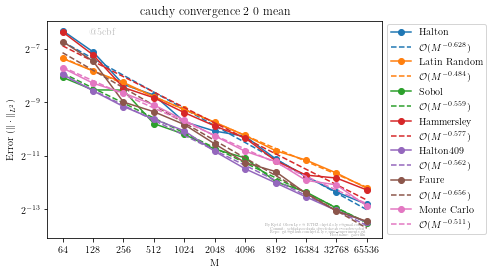

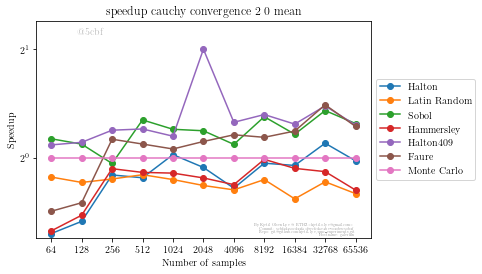

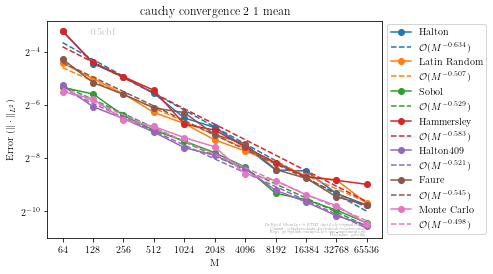

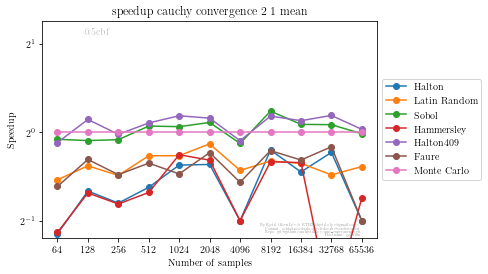

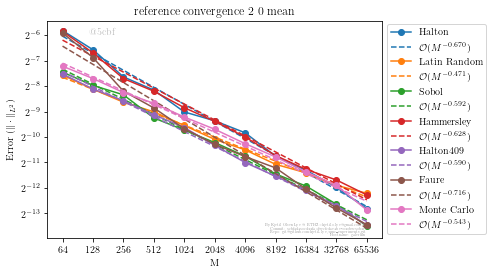

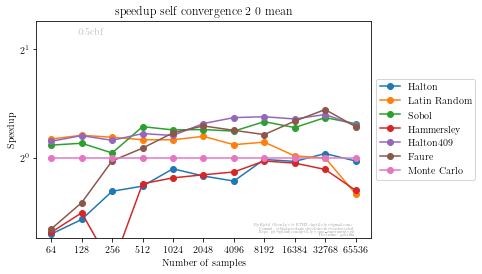

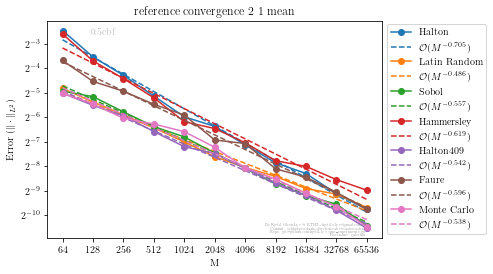

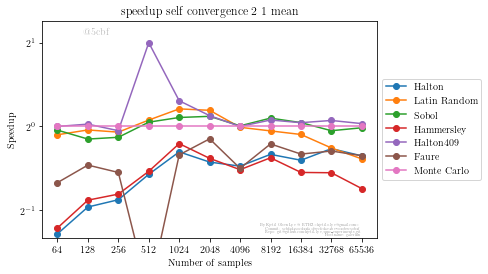

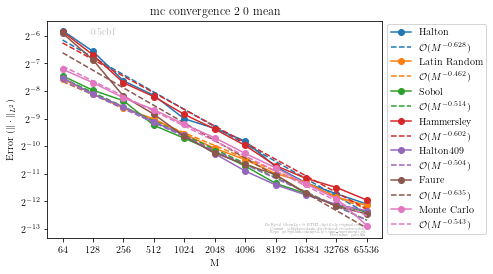

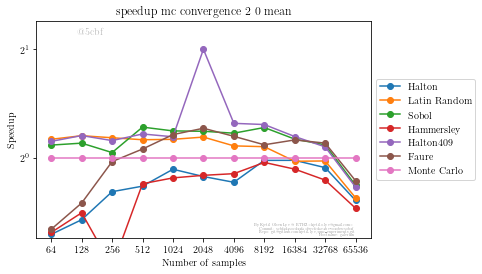

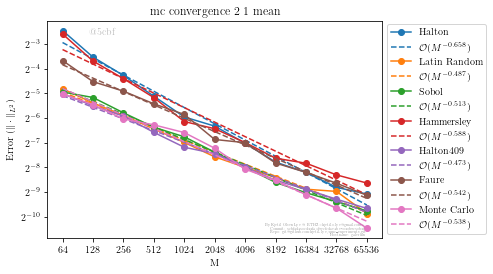

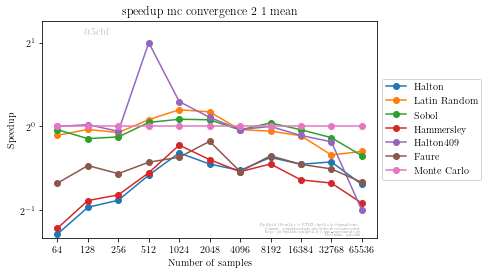

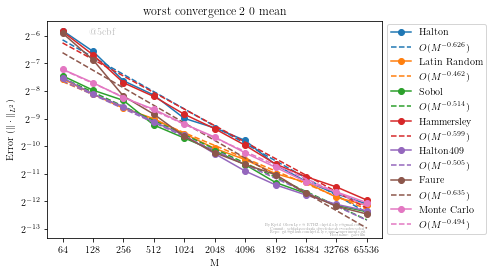

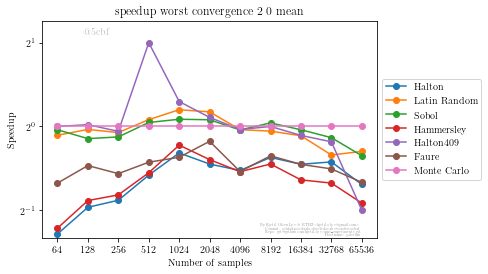

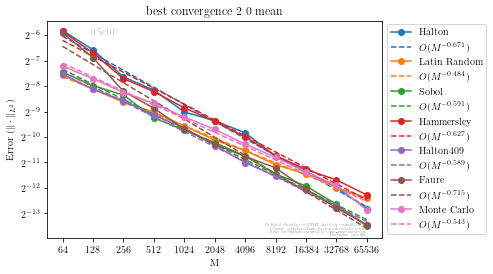

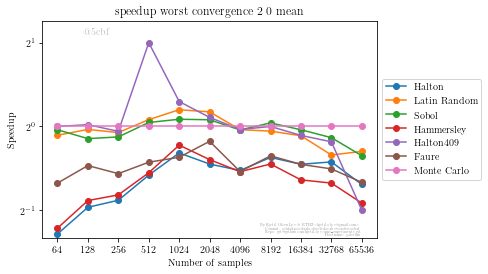

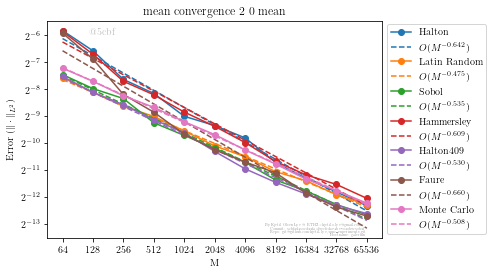

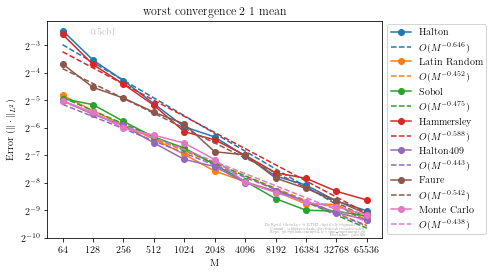

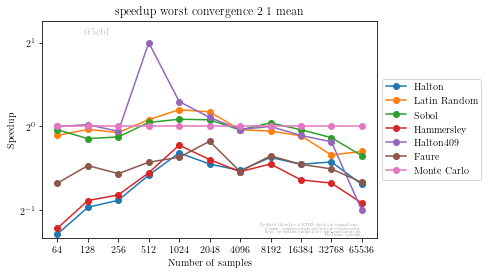

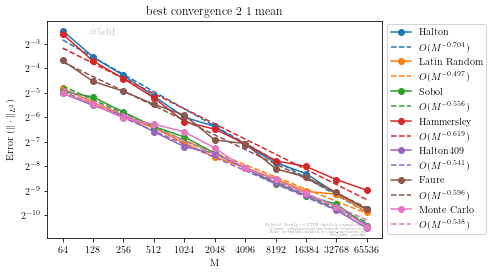

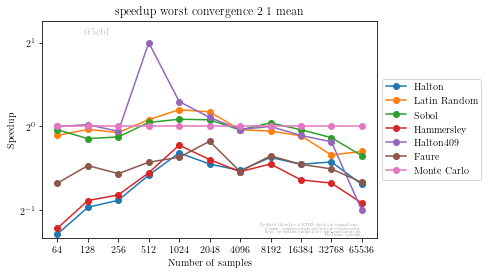

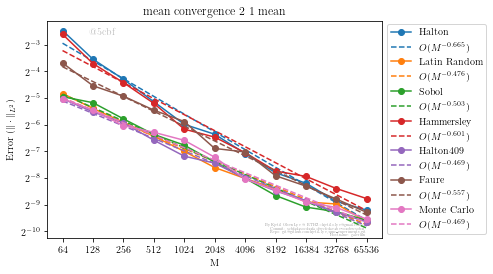

../data/configs_euler/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../data/configs_euler/kelvinhelmholtz_latin_random/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_faure/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml










































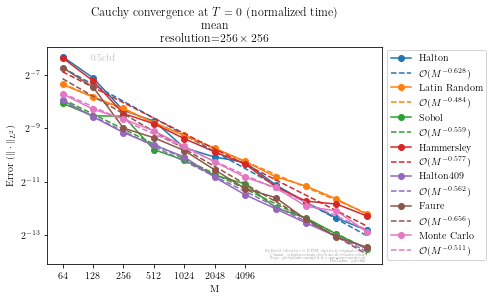

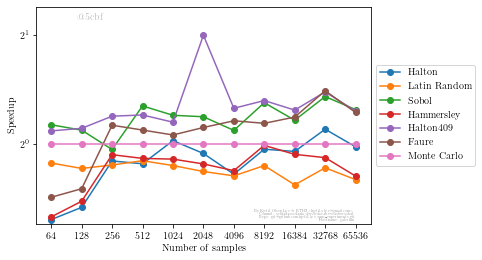

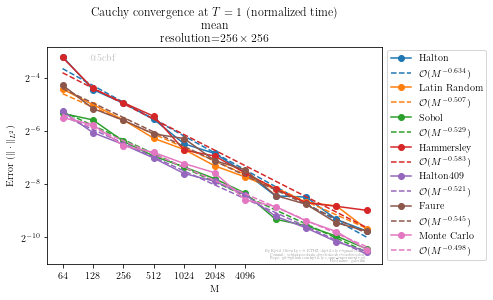

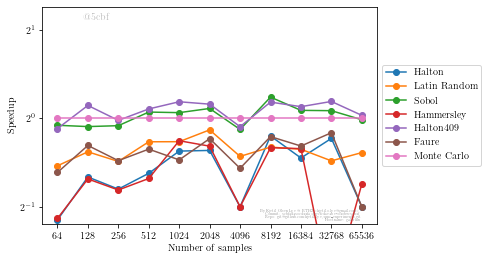

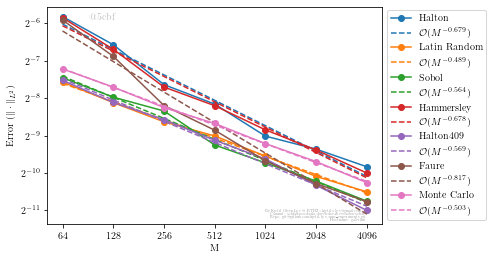

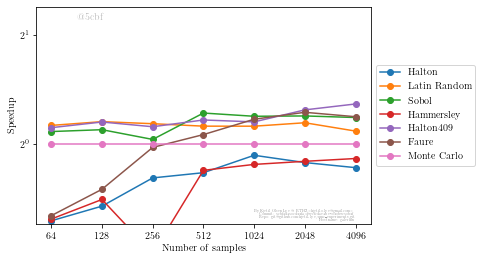

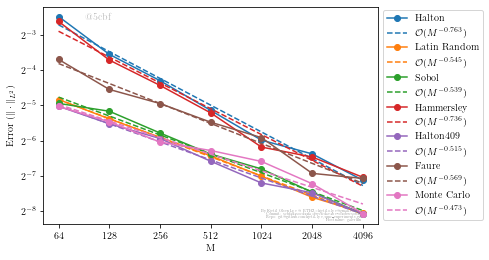

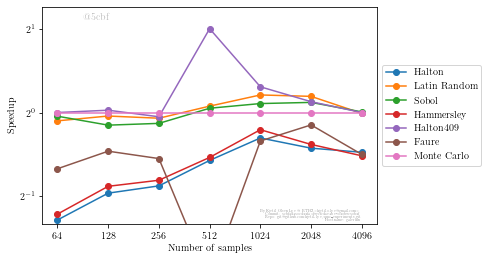

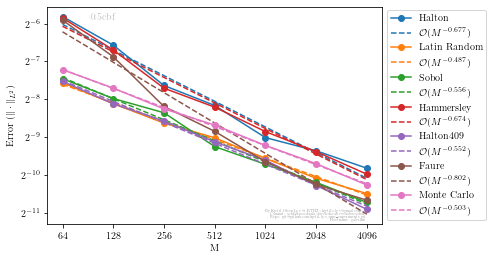

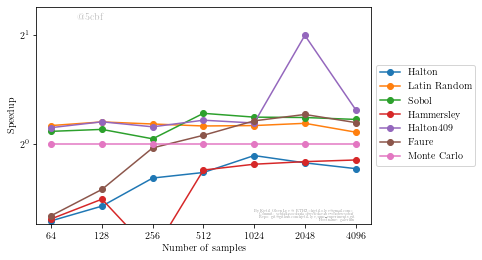

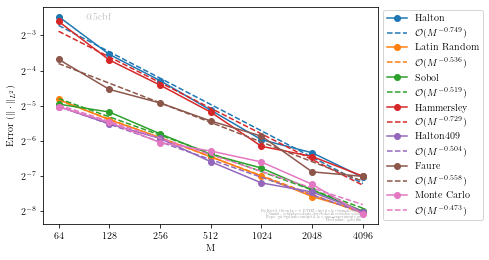

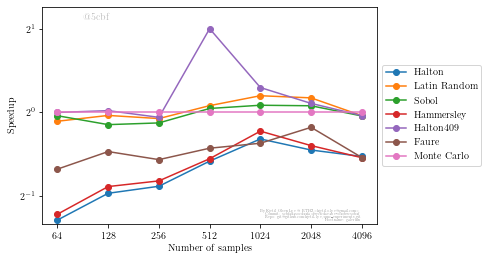

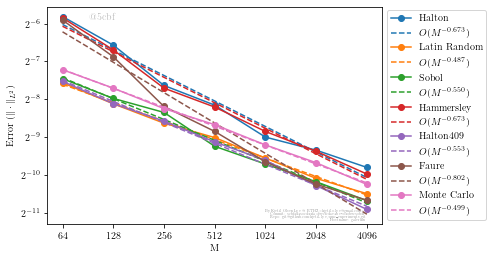

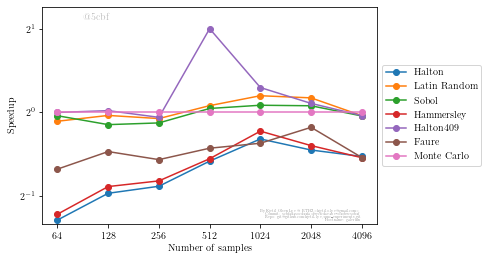

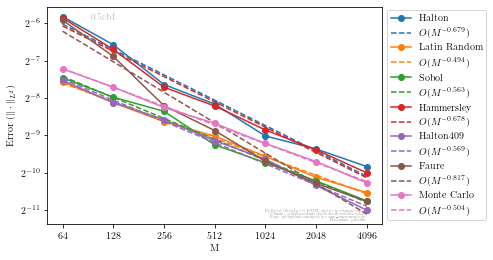

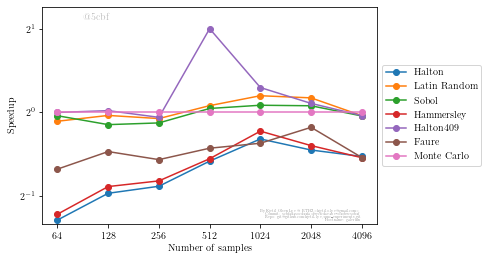

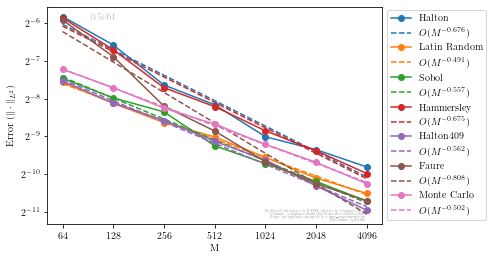

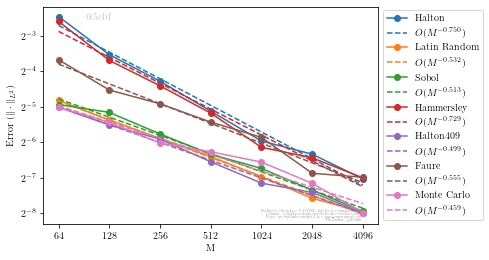

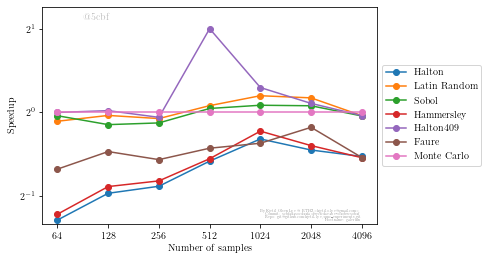

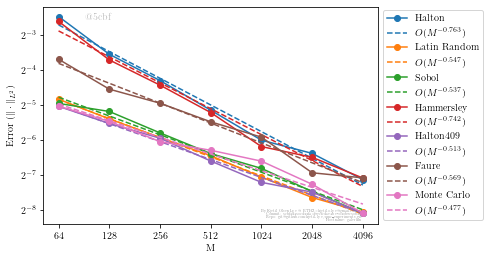

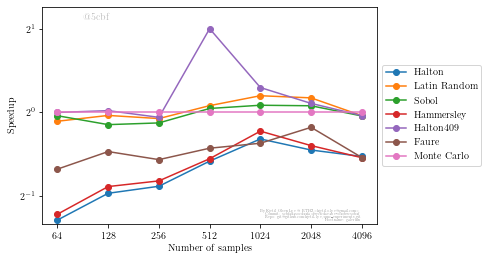

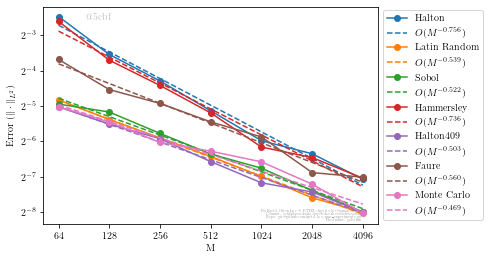

In [4]:
import glob
allFiles = []
for f in glob.glob(os.path.join(qmc_base_folder, "configs_euler/kelvinhelmholtz_*")):
    if not 'nieder' in f and not 'latin_center' in f:
        allFiles.append(f + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml")


# first find monte carlo:

        
for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler/kelvinhelmholtz_*")):
    if 'monte_carlo' in basename:
        _, found_all_mc_errors = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles)
plt.close('all')

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler/kelvinhelmholtz_*")):
    names = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles,
                               all_mc_errors=found_all_mc_errors)
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    plt.title(filename.replace("_", " ").replace(".", ""))
    savePlot(filename)
plt.show()

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler/kelvinhelmholtz_*")):
    names = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles, upTo=-5,
                              all_mc_errors=found_all_mc_errors)
    
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    savePlot("upto_m5_" + filename)
plt.show()



# Variance


../data/configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../data/configs_euler/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_latin_random/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_faure/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml










































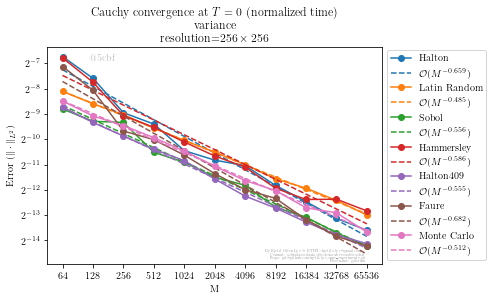

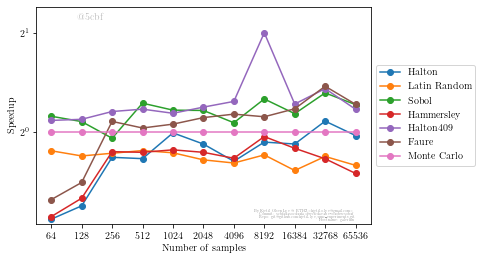

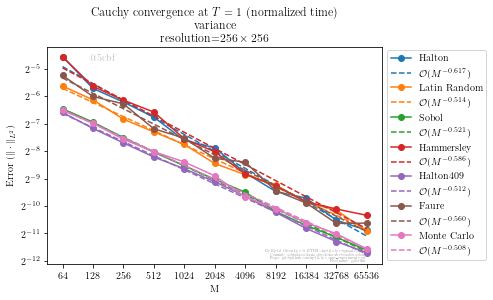

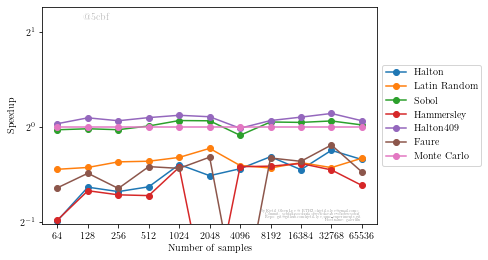

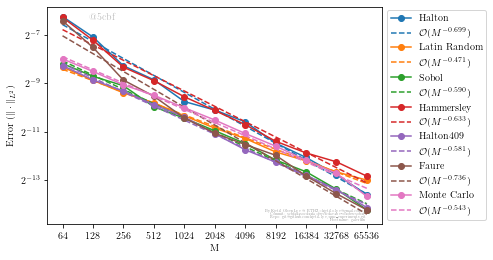

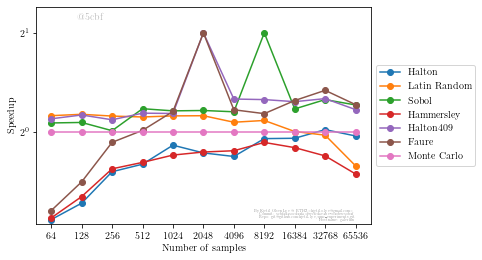

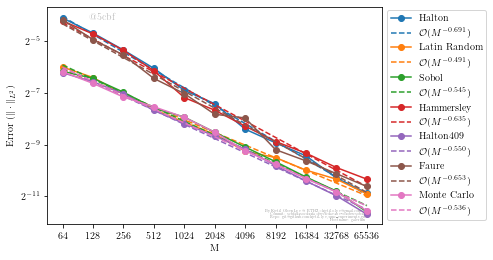

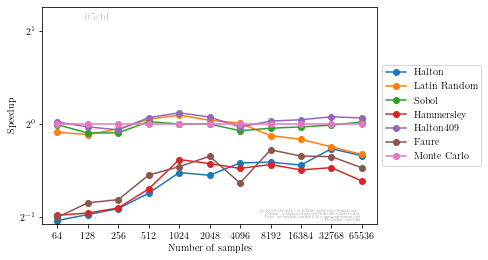

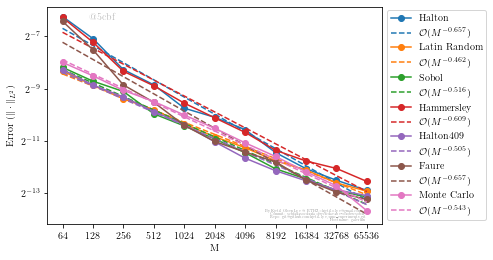

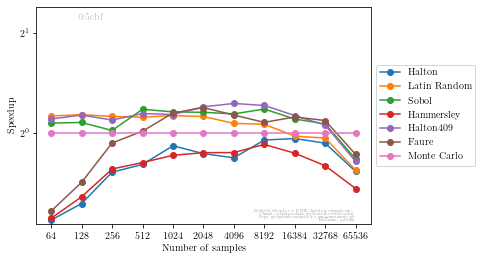

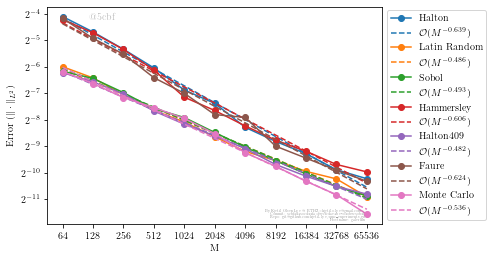

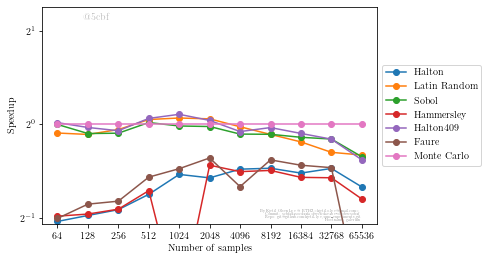

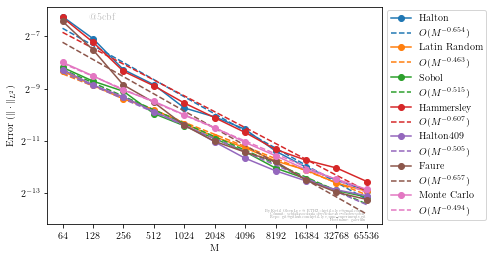

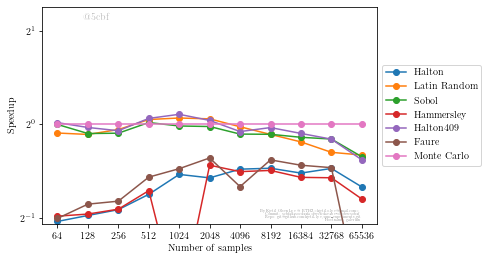

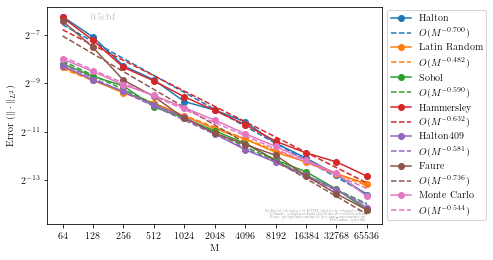

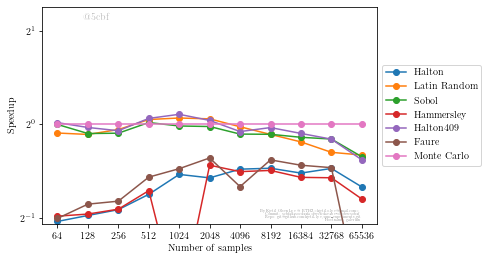

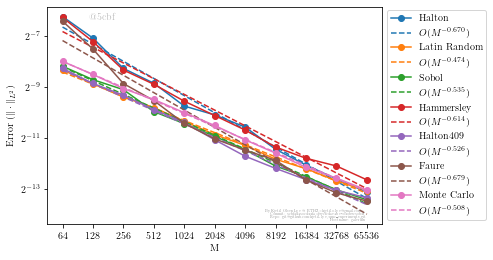

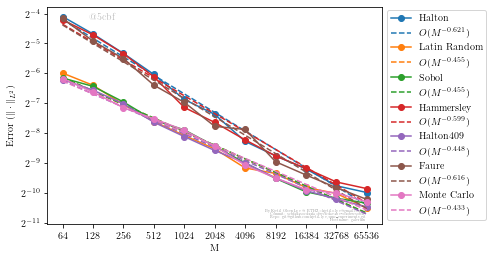

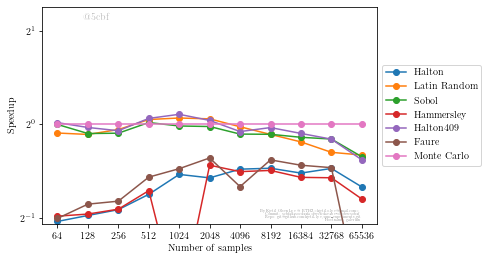

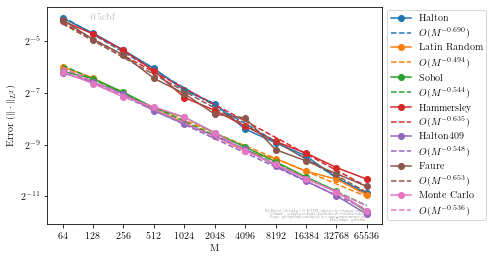

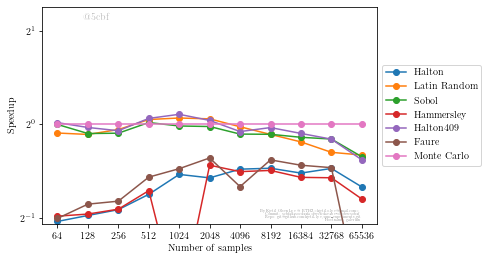

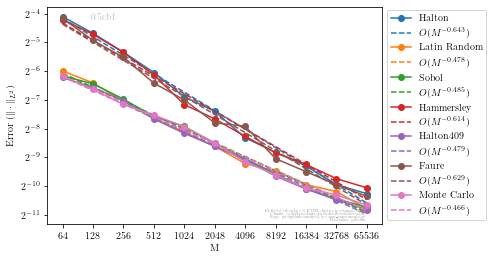

../data/configs_euler/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_latin_random/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_faure/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml










































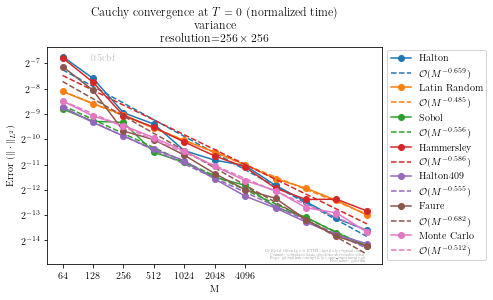

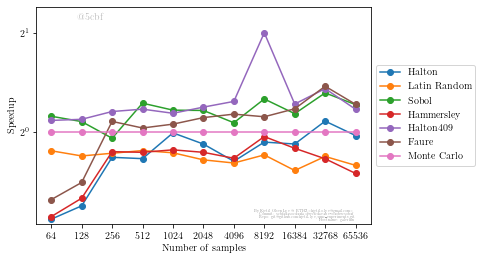

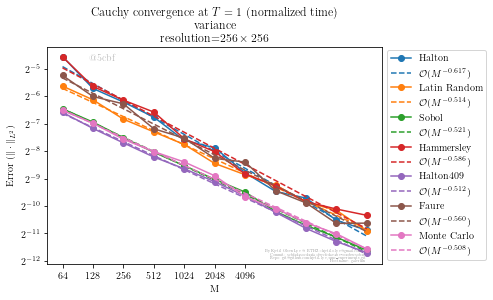

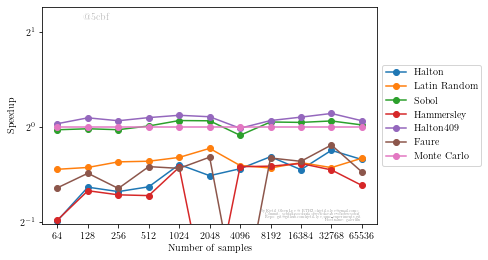

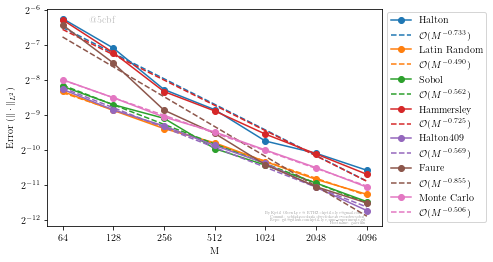

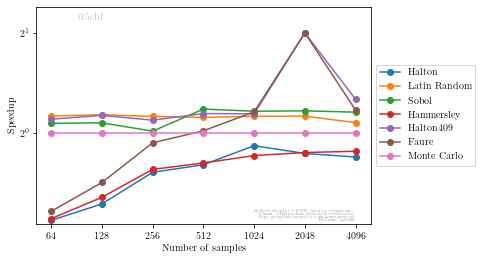

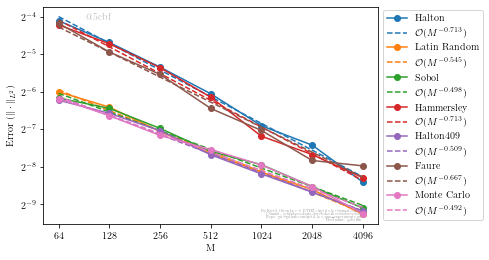

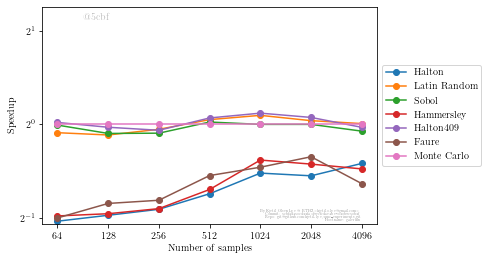

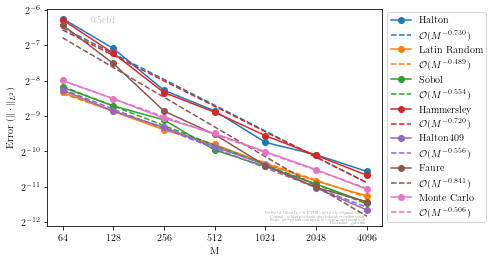

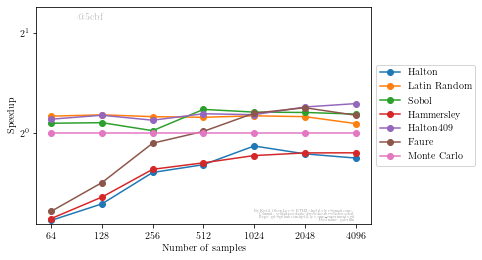

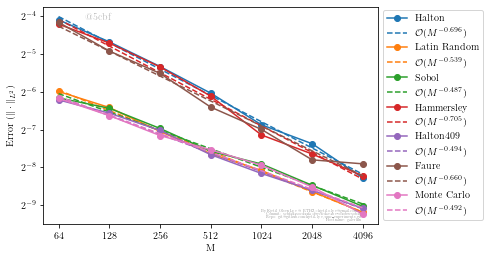

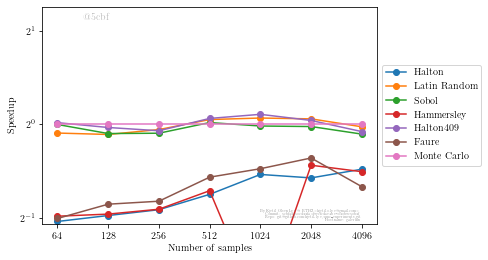

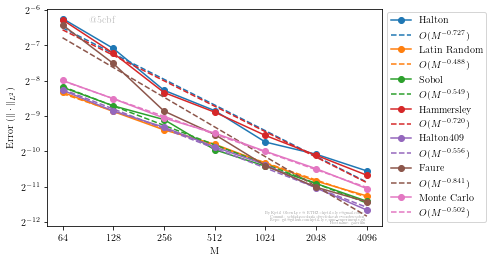

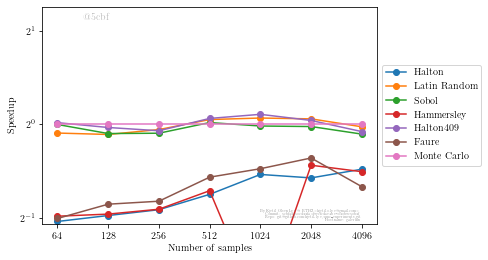

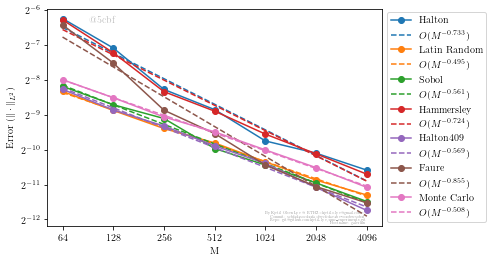

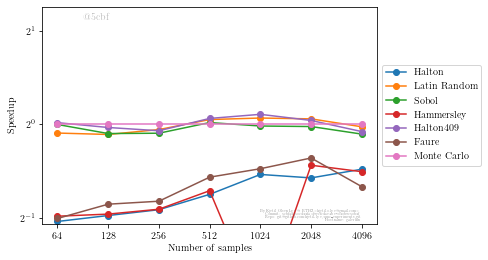

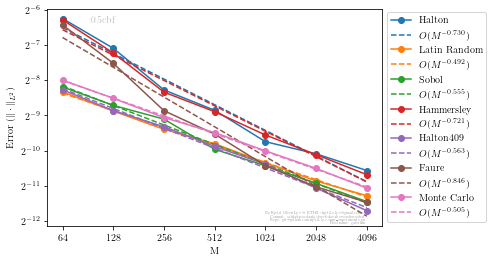

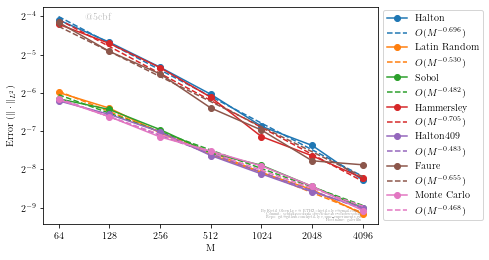

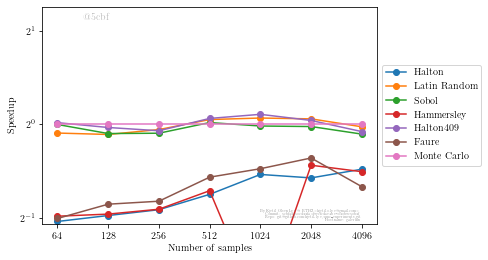

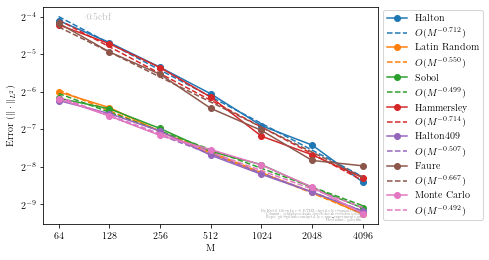

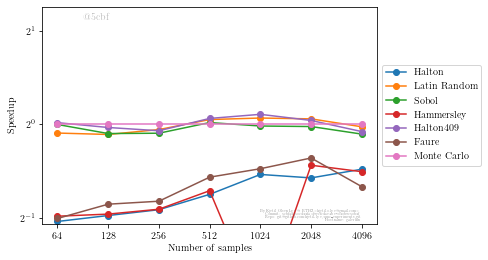

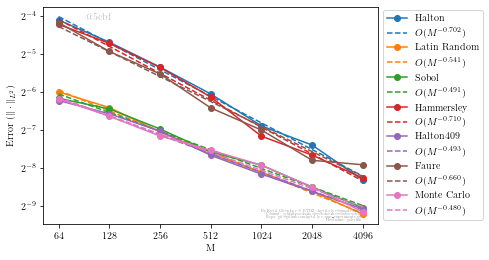

In [5]:


# first find monte carlo:

        
for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler/kelvinhelmholtz_*")):
    if 'monte_carlo' in basename:
        _, found_all_mc_errors = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles,  statistics='variance')
plt.close('all')

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler/kelvinhelmholtz_*")):
    names = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2,
                               allFiles, statistics='variance',
                              all_mc_errors=found_all_mc_errors)
    
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    savePlot(filename)
plt.show()

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler/kelvinhelmholtz_*")):
    names= computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles,
                              upTo=-5, statistics='variance',
                              all_mc_errors=found_all_mc_errors)
    
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    savePlot("upto_m5_" + filename)
plt.show()

# 512 x 512


../data/configs_euler512/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../data/configs_euler512/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


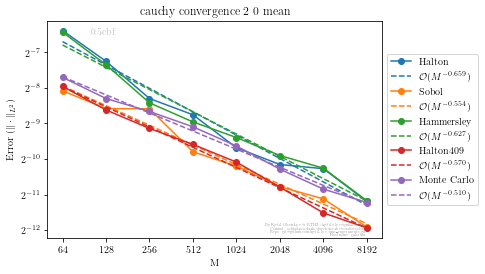

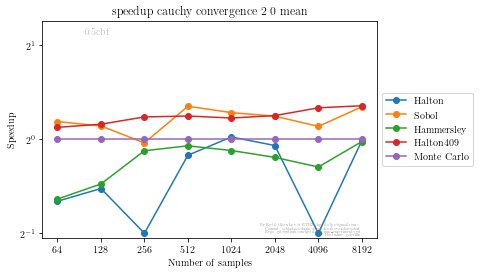

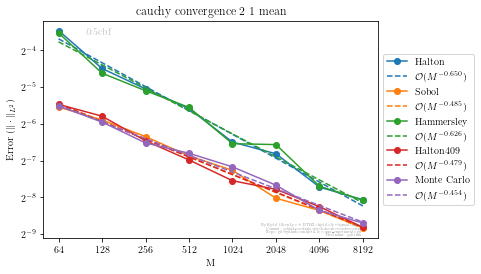

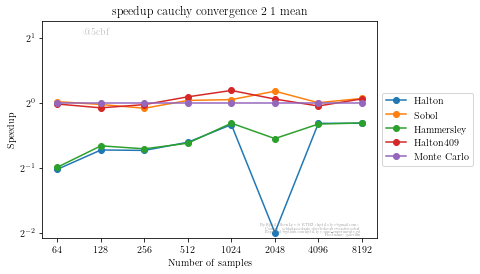

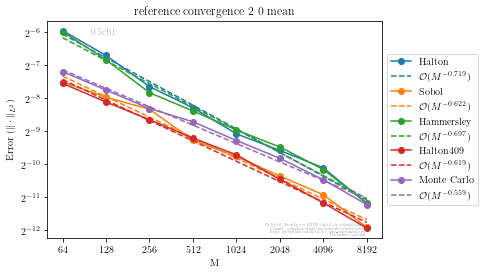

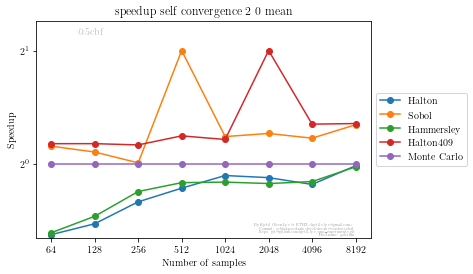

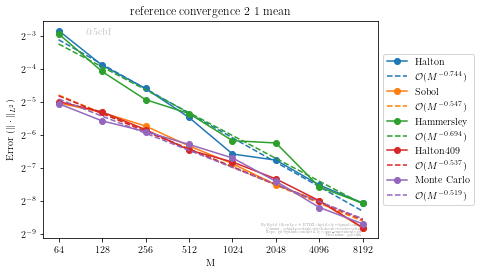

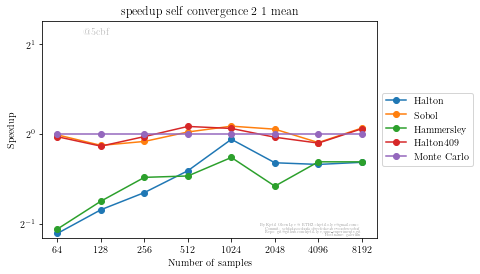

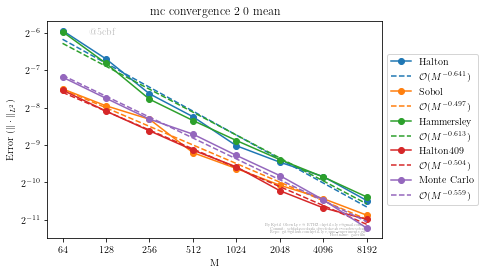

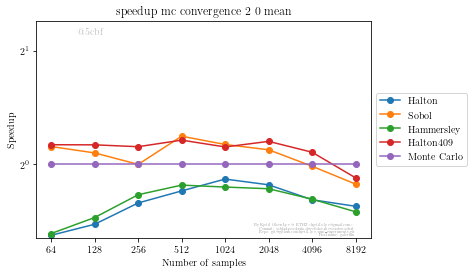

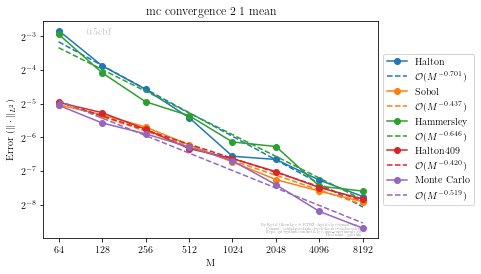

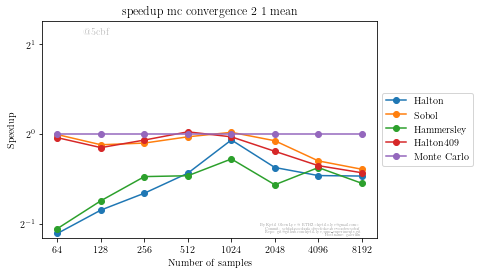

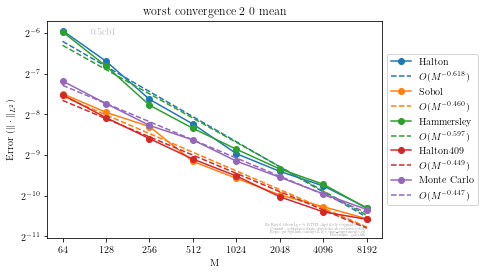

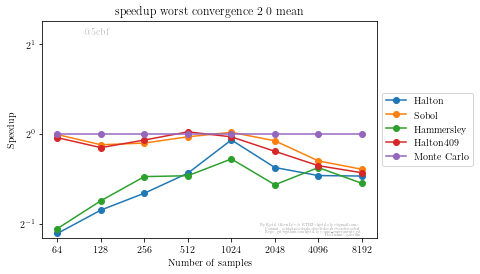

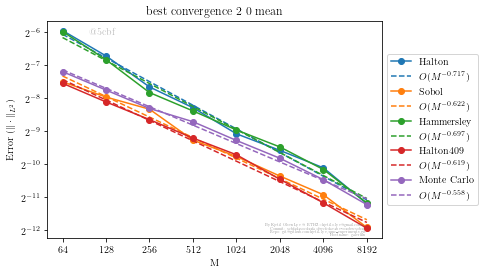

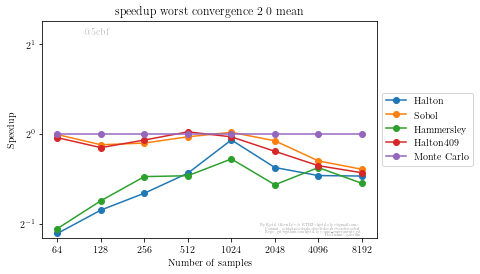

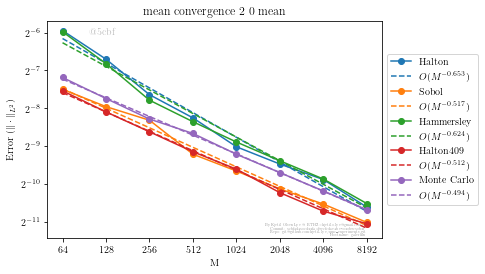

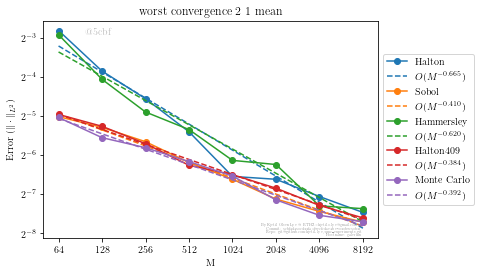

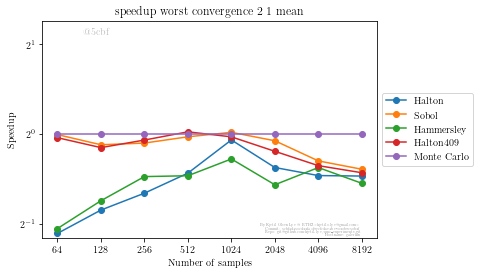

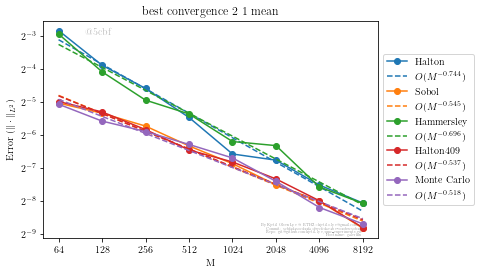

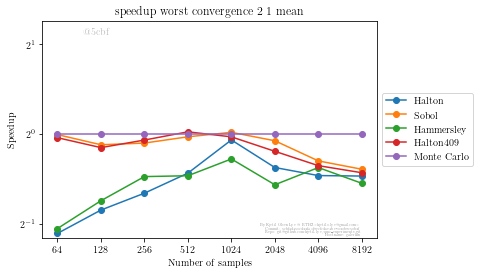

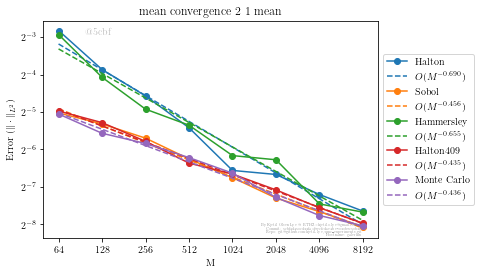

../data/configs_euler512/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml










































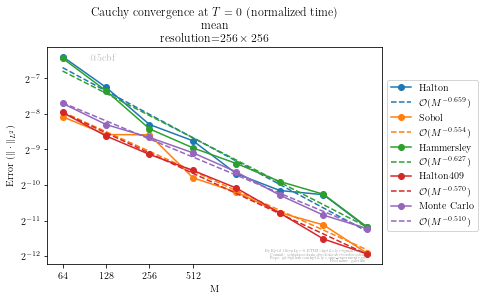

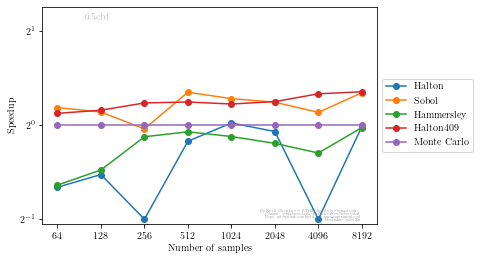

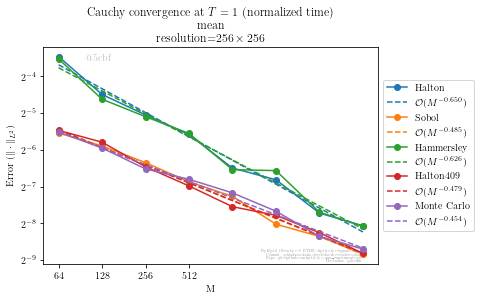

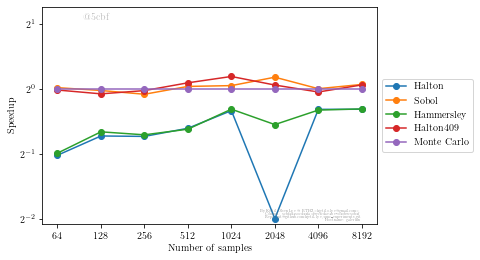

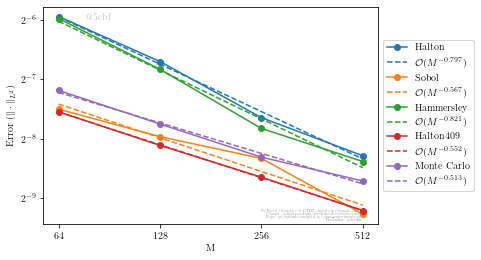

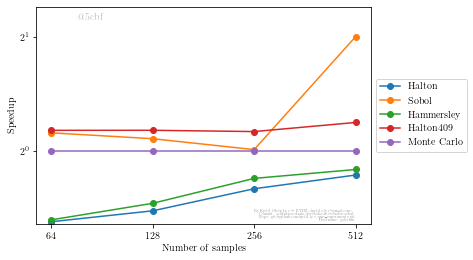

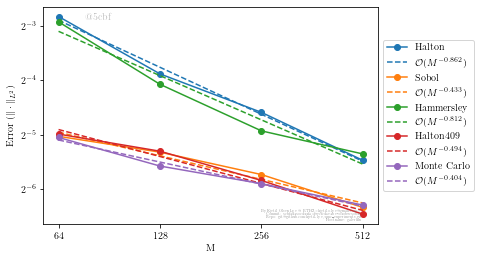

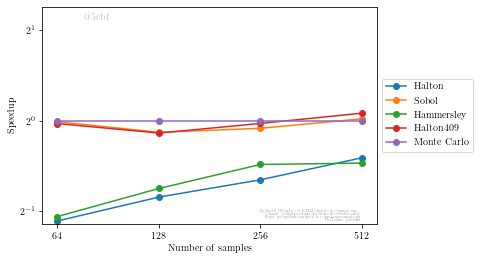

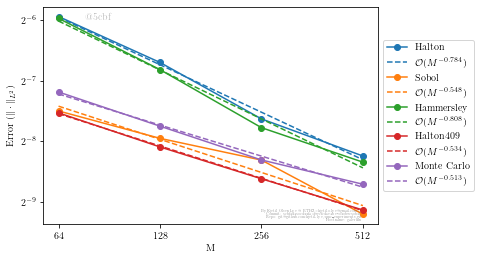

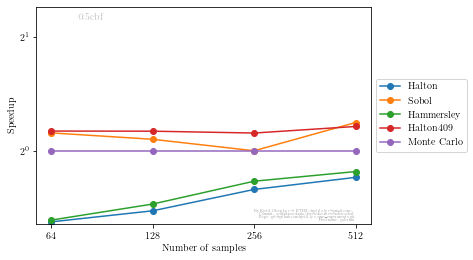

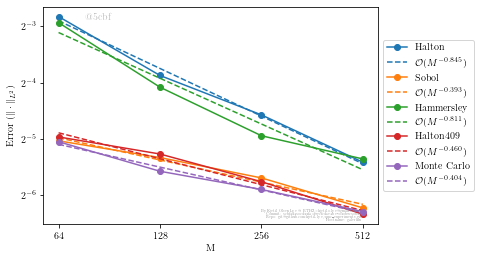

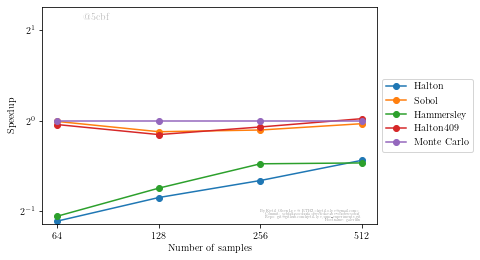

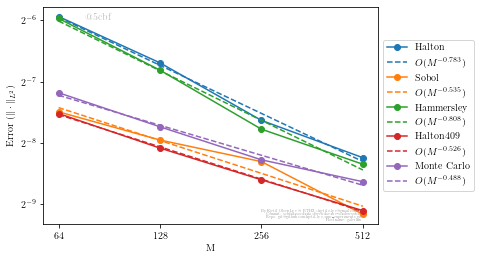

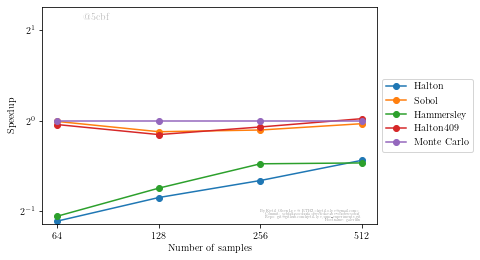

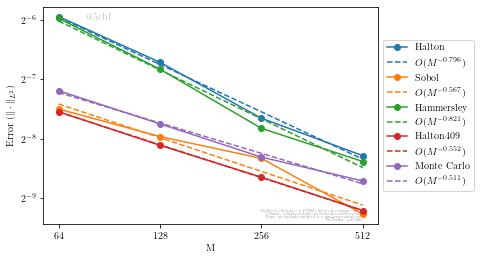

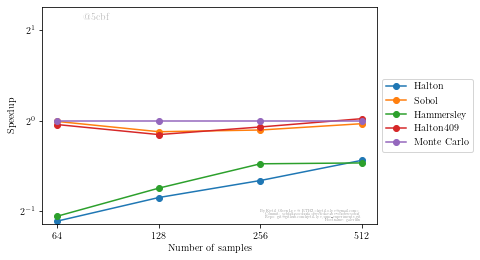

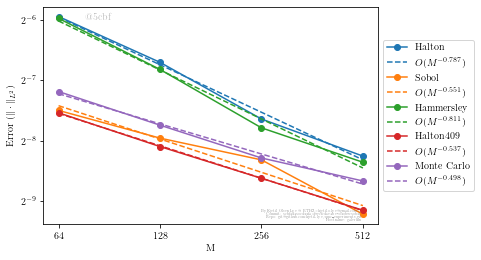

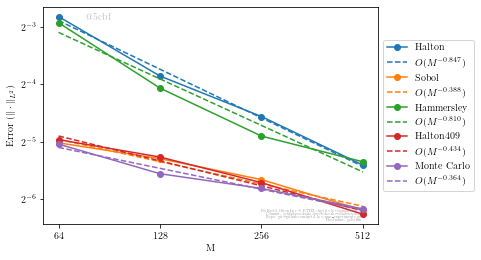

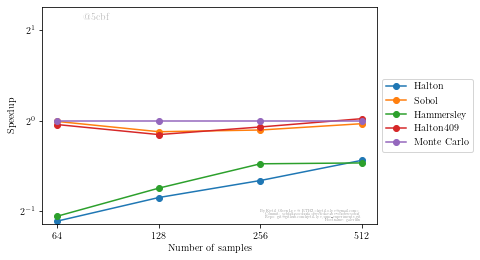

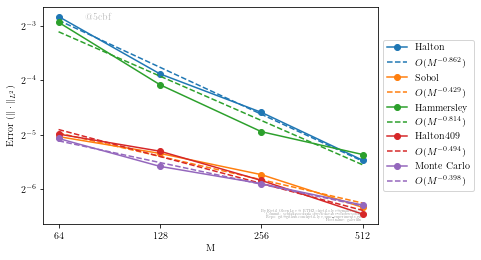

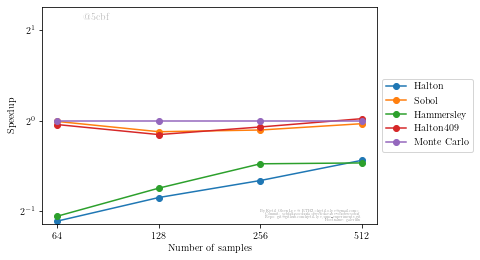

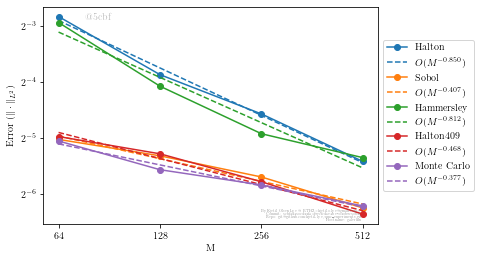

In [6]:

import glob
allFiles = []
for f in glob.glob(os.path.join(qmc_base_folder, "configs_euler512/kelvinhelmholtz_*")):
    if not 'nieder' in f and not 'latin_center' in f:
        allFiles.append(f + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml")


# first find monte carlo:

        
for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler512/kelvinhelmholtz_*")):
    if 'monte_carlo' in basename:
        _, found_all_mc_errors = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 
                                                    2, allFiles, maxMexponent=15)
plt.close('all')

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler512/kelvinhelmholtz_*")):
    names = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles,
                               all_mc_errors=found_all_mc_errors, maxMexponent=15)
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    plt.title(filename.replace("_", " ").replace(".", ""))
    savePlot(f"r512_{filename}")
plt.show()

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler512/kelvinhelmholtz_*")):
    names = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles, upTo=-5,
                              all_mc_errors=found_all_mc_errors, maxMexponent=15)
    
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    savePlot(f"r512_upto_m5_{filename}")
plt.show()





# Variance

../data/configs_euler512/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../data/configs_euler512/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml










































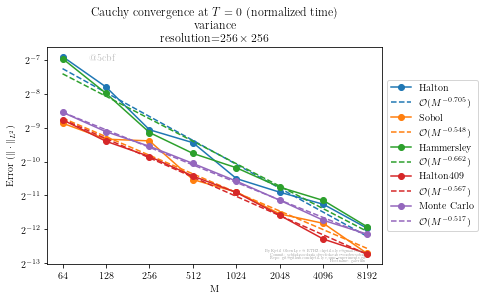

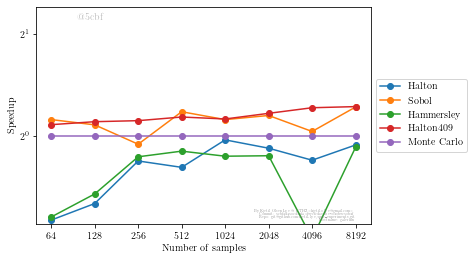

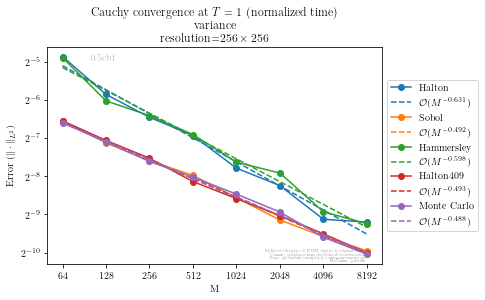

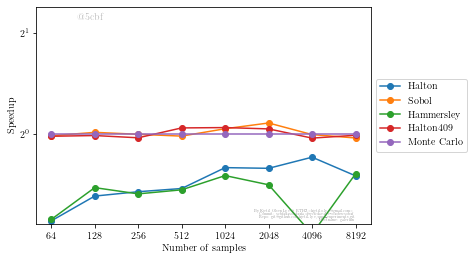

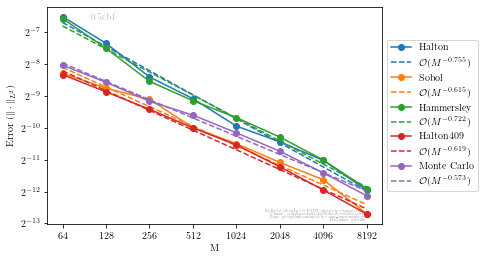

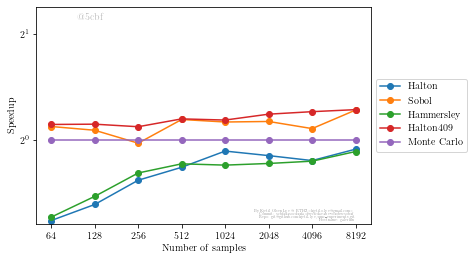

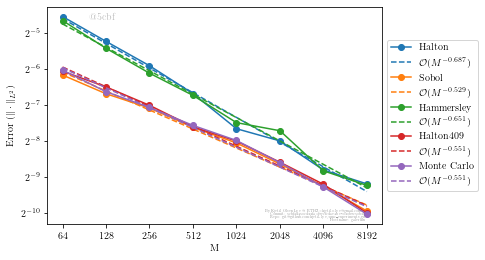

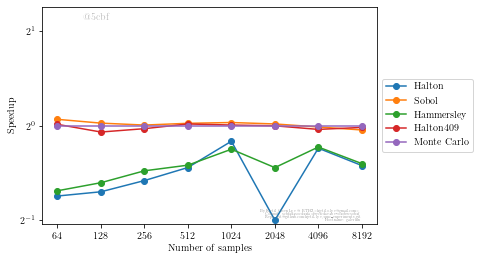

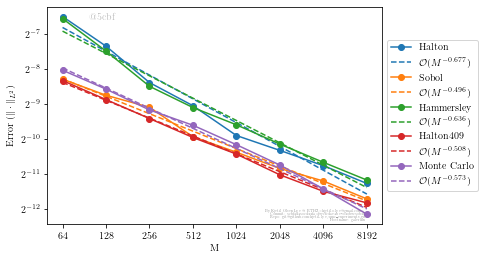

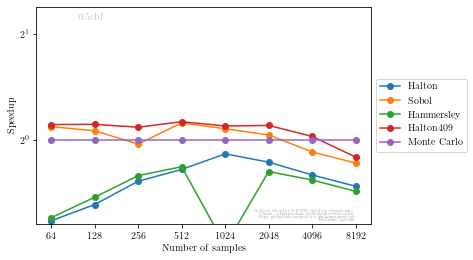

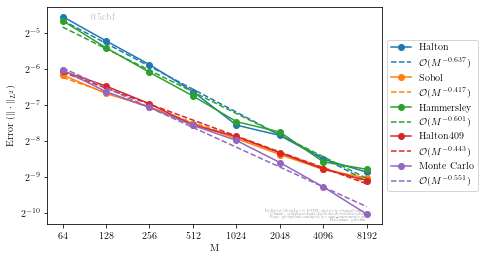

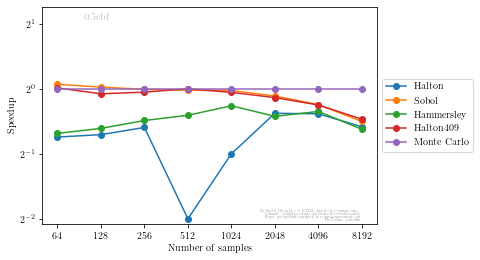

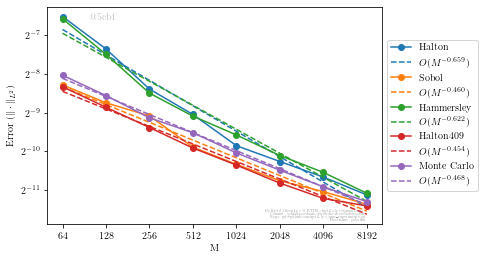

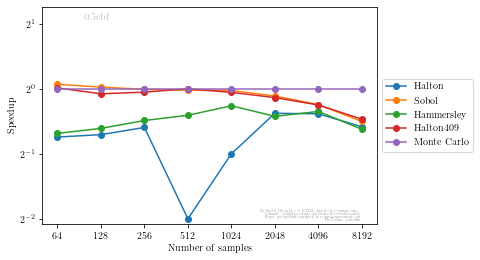

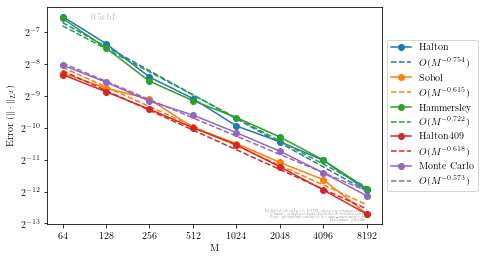

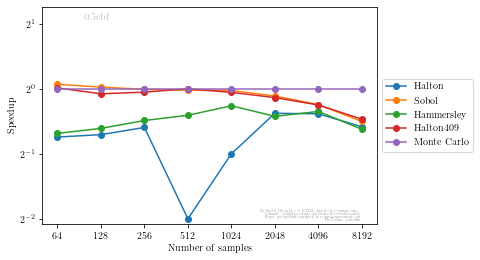

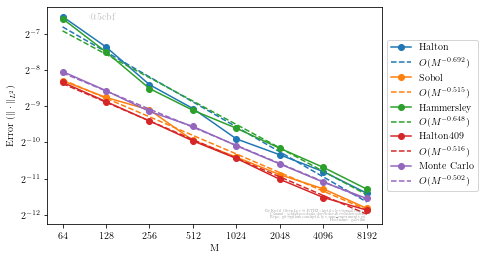

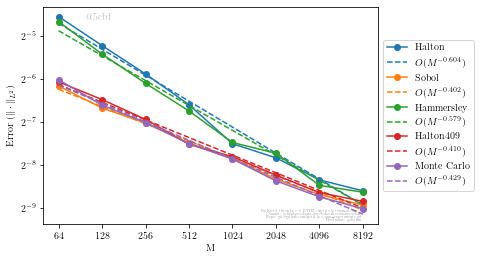

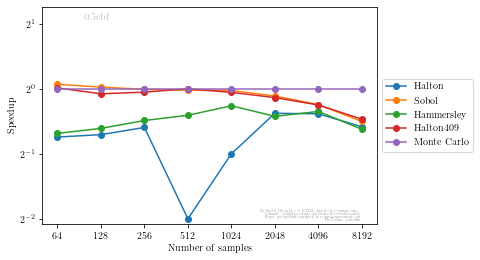

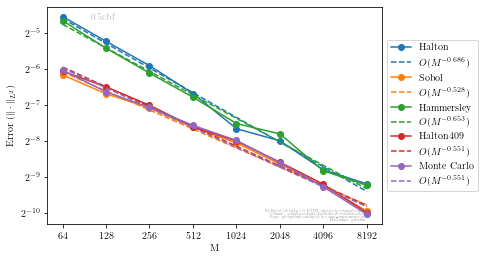

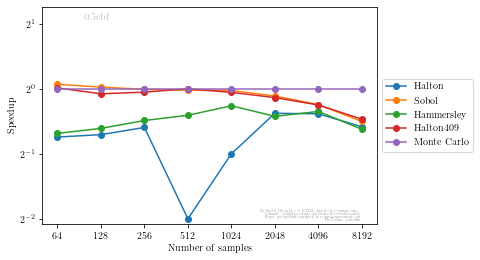

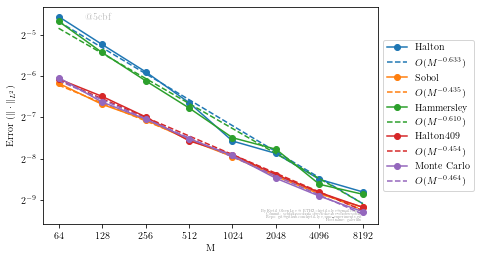

../data/configs_euler512/kelvinhelmholtz_halton/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../data/configs_euler512/kelvinhelmholtz_sobol/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_hammersley/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_halton409/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml
../data/configs_euler512/kelvinhelmholtz_monte_carlo/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml










































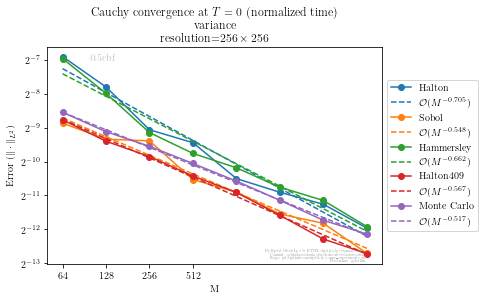

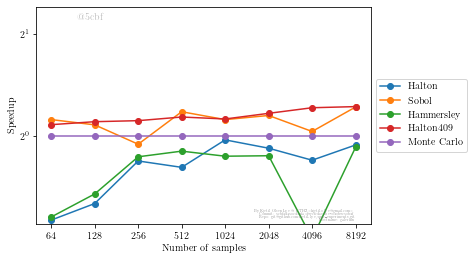

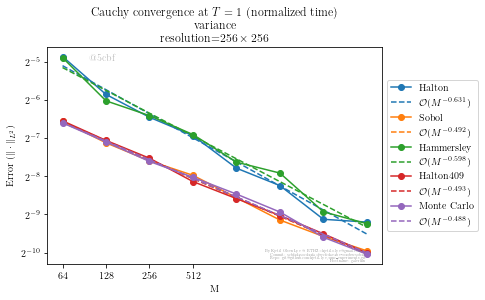

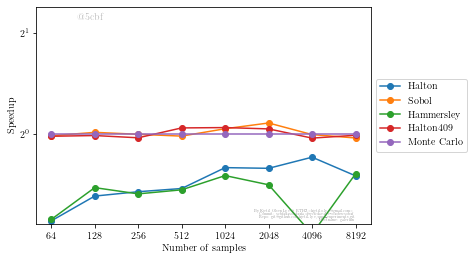

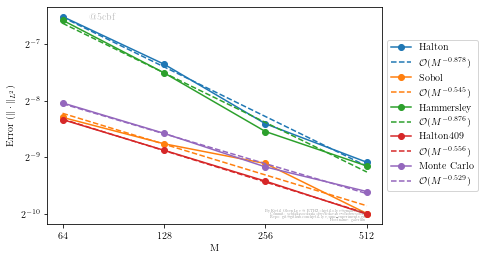

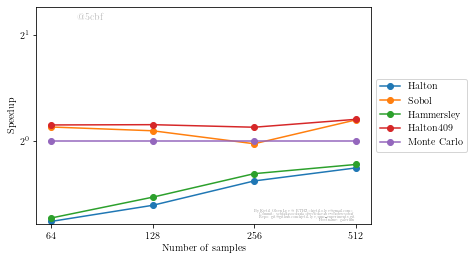

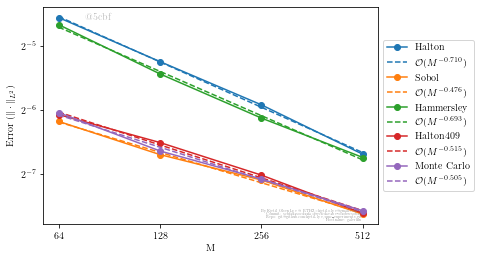

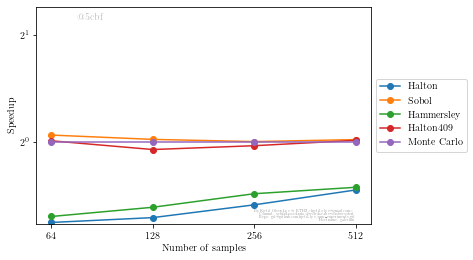

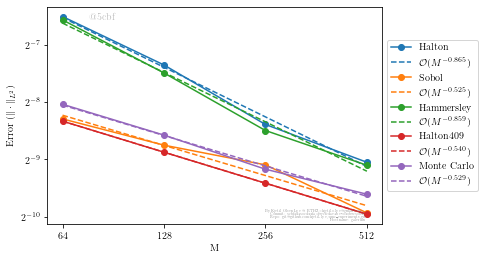

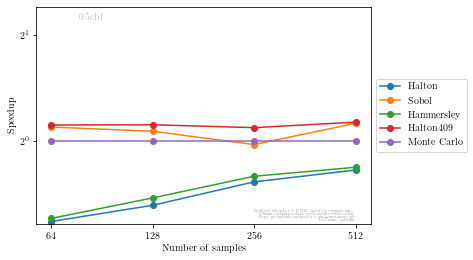

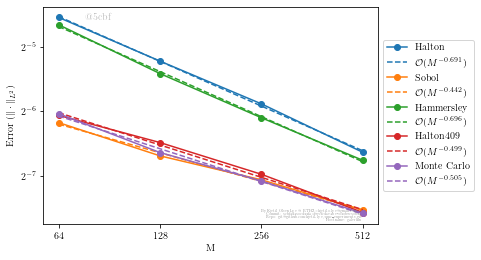

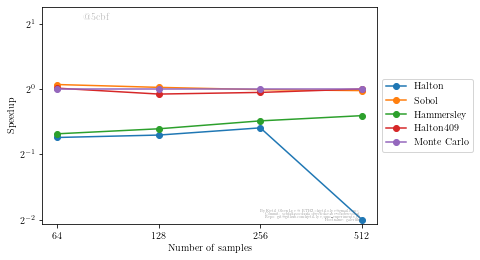

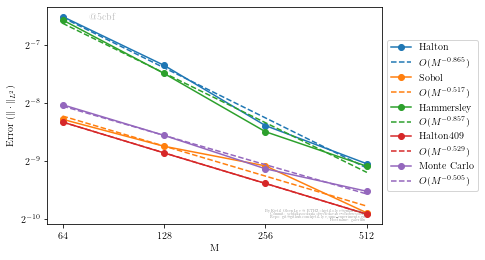

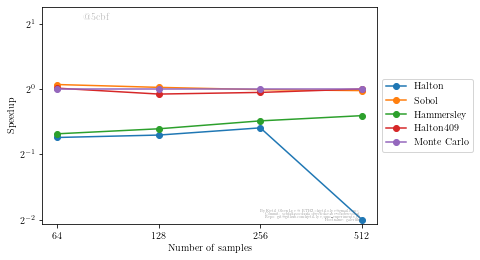

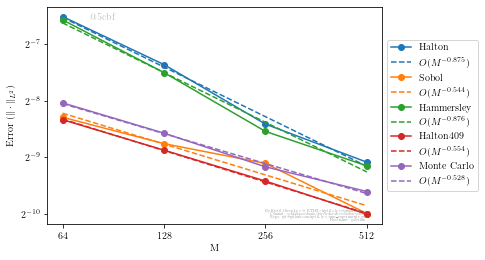

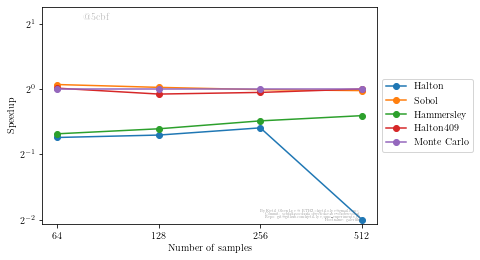

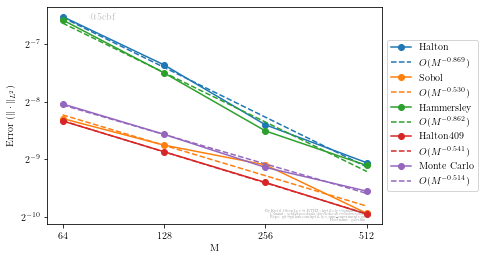

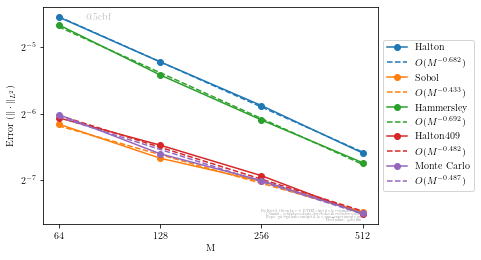

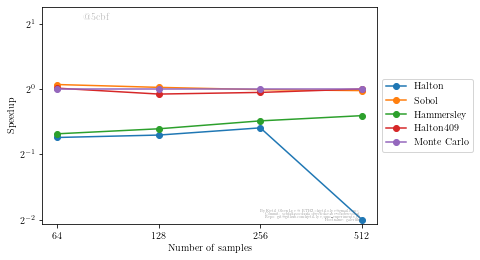

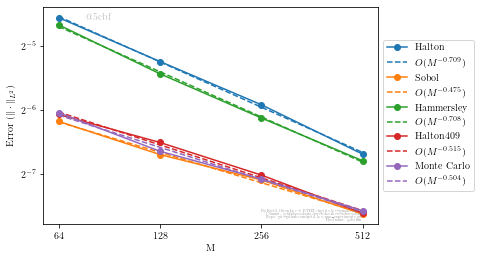

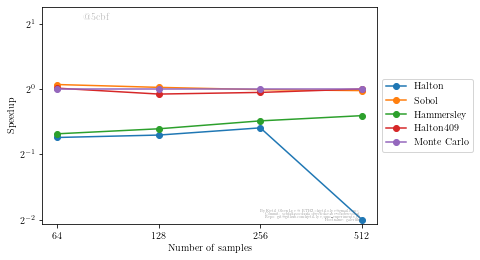

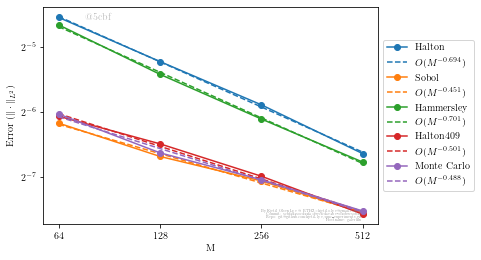

In [7]:


# first find monte carlo:

        
for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler512/kelvinhelmholtz_*")):
    if 'monte_carlo' in basename:
        _, found_all_mc_errors = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2,
                                                    allFiles,  statistics='variance', maxMexponent=15)
plt.close('all')

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler512/kelvinhelmholtz_*")):
    names = computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2,
                               allFiles, statistics='variance',
                              all_mc_errors=found_all_mc_errors, maxMexponent=15)
    
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    savePlot('r512_' + filename)
plt.show()

for basename in glob.glob(os.path.join(qmc_base_folder, "configs_euler512/kelvinhelmholtz_*")):
    names= computeConvergence(basename + "/m{M}/kelvinhelmholtz/kelvinhelmholtz.xml", 2, allFiles,
                              upTo=-5, statistics='variance',
                              all_mc_errors=found_all_mc_errors, maxMexponent=15)
    
names = names[0]
for (figure_number, filename) in names.items():
    plt.figure(figure_number)
    legendLeft()
    savePlot("r512_upto_m5_" + filename)
plt.show()